In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import median_filter
from sklearn.model_selection import train_test_split
import warnings
import logging
from tqdm import tqdm
from keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, concatenate, Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Conv1D, Activation, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

seed = 42

2.10.0


In [2]:
training_labels = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe": 4,
    "Time": 5,
    "Brain": 6,
    "Echoes": 7,
    "Wearing": 8,
    "Sorrow": 9,
    "Hey": 10,
    "Shine": 11,
}

### DATA PREPARATION

In [3]:
data = np.load("../../data/x_train.npy")
target = np.load("../../data/y_train.npy")

In [4]:
#SHUFFLE DATA
np.random.seed(42)
p = np.random.permutation(data.shape[0])
data = data[p]
target = target[p]

In [5]:
data[0].shape

(36, 6)

# SPLIT DATA INTO TRAIN / TEST
- Split data into Train and test seqeuences using sequence ID
- We also convert target into OneHotEncoding
- Normalize Data using MinMax Scaler


In [6]:
test_split = 0.2
val_split = 0.1
#OneHotEncoding
target = tfk.utils.to_categorical(target)

#Split Train Test
x_train,x_test,y_train,y_test = train_test_split(data,target, test_size=test_split,random_state=42,stratify=target)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=val_split,random_state=42,stratify=y_train)
x_train.shape,x_test.shape,x_val.shape

((1748, 36, 6), (486, 36, 6), (195, 36, 6))

In [7]:
def normalize_single_series(data):
  for i in tqdm(range(0,data.shape[0])):
    chunck = data[i]
    mean = np.mean(chunck)
    std  = np.std(chunck)
    data[i] = (chunck - mean) / std
  return data


In [8]:
x_old = x_train.copy()
x_train = normalize_single_series(x_train)
x_test  = normalize_single_series(x_test)
x_val   = normalize_single_series(x_val)

x_train.shape

100%|██████████| 195/195 [00:00<00:00, 60223.05it/s]


(1748, 36, 6)

In [9]:
def add_noise(seq,weight=0.005):
  #Copy Data
  seq = np.array(seq)
  seq = seq.copy()
  #Calculate STD
  std = np.std(seq) * weight
  #Calculate Mean of this sequence
  noise = np.random.normal(0,std,seq.shape)

  data_augmented = seq + noise*0.1
  return data_augmented

In [10]:
augmentation = True #NOW IS FALSE SINCE IS TO CORRECT THE WAY IT ADD NOISE
np.random.seed(60)

y_new = y_train.copy()
x_new = x_train.copy()
if augmentation:
  weights = [0.01,0.02,0.03, 0.04,0.05, 0.06]
  for w in weights:
    for i in tqdm(range(0,x_train.shape[0])):
      aug = add_noise(x_train[i],w)
      aug = np.expand_dims(aug, axis=0)
      #print(aug.shape,x_new.shape)
      #print(y_new.shape,y_train.shape)
      x_new    = np.vstack([x_new,aug])
      y_new    = np.vstack([y_new,y_train[i]])

x_train_aug1  = x_new
y_train_aug1  = y_new
x_train.shape,y_train.shape, x_train_aug1.shape, y_train_aug1.shape

100%|██████████| 1748/1748 [00:03<00:00, 458.26it/s]


((1748, 36, 6), (1748, 12), (12236, 36, 6), (12236, 12))

# Augmentation

In [11]:
import utils.augmentation as aug

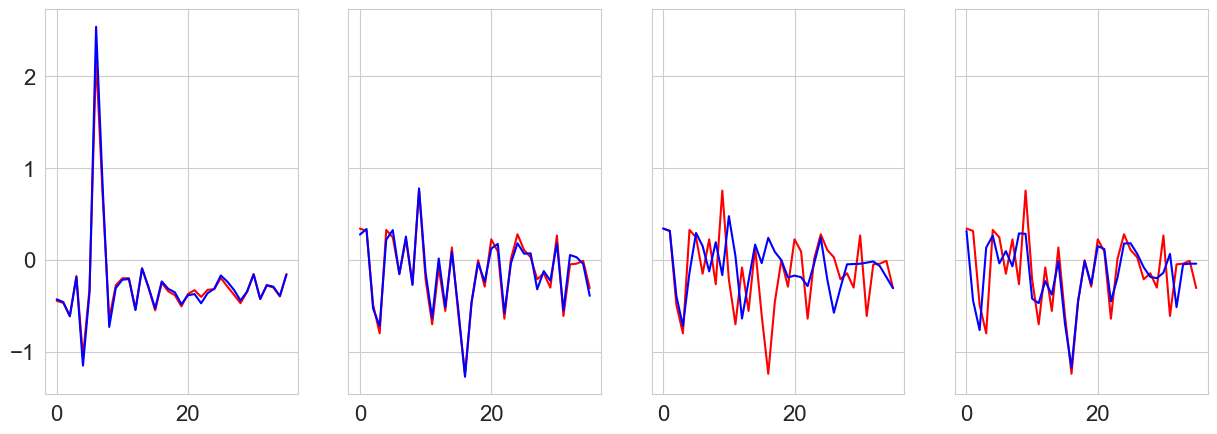

In [12]:
fig, ax =  plt.subplots(1, 4, figsize=(15, 5), sharey=True)

ax[0].plot(x_train[0, :, 0], color="red")
ax[0].plot(aug.magnitude_warp(x_train, sigma=0.1, knot=10)[0, :, 0], color="blue")

ax[1].plot(x_train[2, :, 0], color="red")
ax[1].plot(aug.jitter(x_train, sigma=0.06)[2, :, 0], color="blue")

ax[2].plot(x_train[2, :, 0], color="red")
ax[2].plot(aug.time_warp(x_train)[2, :, 0], color="blue")

ax[3].plot(x_train[2, :, 0], color="red")
ax[3].plot(aug.window_slice(x_train)[2, :, 0], color="blue")

plt.show()

In [13]:
x_train = np.append(x_train, aug.jitter(x_train, sigma=0.06)[:3000], axis=0)
y_train = np.append(y_train, y_train[:3000], axis=0)
x_train = np.append(x_train, aug.magnitude_warp(x_train, sigma=0.1, knot=10)[:3000], axis=0)
y_train = np.append(y_train, y_train[:3000], axis=0)
x_train = np.append(x_train, aug.time_warp(x_train)[:3000], axis=0)
y_train = np.append(y_train, y_train[:3000], axis=0)
x_train = np.append(x_train, aug.window_slice(x_train)[:3000], axis=0)
y_train = np.append(y_train, y_train[:3000], axis=0)

x_train = np.append(x_train, x_train_aug1, axis=0)
y_train = np.append(y_train, y_train_aug1, axis=0)


indexes = np.random.choice(x_train.shape[0], x_train.shape[0])
x_train = x_train[indexes]
y_train = y_train[indexes]

In [14]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

# NOW USE THE GENERATED TIME SERIES TO TRAIN OUR MODELS

Vanilla Attempts:
-CNN1D :

In [15]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [16]:
x_train.shape, y_train.shape

((24732, 36, 6), (24732, 12))

In [19]:

# build a network to classify data series with Conv1D
def build_4_layers_conv1d_network(input_shape, classes, learning_rate=0.001, momentum=0.9, loss="categorical_crossentropy",
                                  metrics=["accuracy"]):
    """
    Builds 4 layers Conv1D network for data series.
    """
    # Define the model input
    input = Input(shape=input_shape)

    y = tfkl.LSTM(units=128, return_sequences=True)(input)
    y = tfkl.LSTM(units=256, return_sequences=True)(y)
    y = tfkl.LSTM(units=512)(y)
    y = tfkl.Dropout(0.5)(y)
    # y = tfkl.Dense(512)

    # # Apply convolutional layers
    x = tfkl.Conv1D(filters=32, kernel_size=7, strides=1, padding="same")(input)
    x = tfkl.Activation("sigmoid")(x)

    x = tfkl.Conv1D(filters=64, kernel_size=5, strides=1, padding="same")(x)
    x = tfkl.Activation("sigmoid")(x)

    x = tfkl.Dense(units=128)(x)
    x = tfkl.Activation("sigmoid")(x)
    x = tfkl.BatchNormalization()(x)



    x = tfkl.Conv1D(filters=128, kernel_size=3, strides=1, padding="same")(x)
    x = tfkl.Activation("sigmoid")(x)

    x = tfkl.Dense(units=256)(x)
    x = tfkl.Activation("sigmoid")(x)
    x = tfkl.BatchNormalization()(x)


    x = tfkl.Conv1D(filters=256, kernel_size=1, strides=1, padding="same")(x)
    x = tfkl.Activation("sigmoid")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.GlobalAveragePooling1D()(x)

    x = tfkl.Flatten()(x)
    x = tfkl.Dense(units=512)(x)
    x = tfkl.Dropout(0.5)(x)

    x = tfkl.Add()([y, x])


    x = tfkl.Dense(units=classes)(x)
    x = tfkl.Activation("softmax")(x)

    # Define the model
    model = Model(inputs=input, outputs=x)

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss=loss, metrics=metrics)

    return model

model = build_4_layers_conv1d_network(input_shape, classes)
model.summary()
# tfk.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 36, 32)       1376        ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 36, 32)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 36, 64)       10304       ['activation[0][0]']             
                                                                                              

In [20]:
# model = tf.keras.models.load_model("modello_a_caso")
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-18 15:22:07.888486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-18 15:22:10.955031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 15:22:11.273890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 15:22:11.428463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 15:22:11.649909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 15:22:12.098977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 15:22:12.450352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

194/194 [==============================] - ETA: 0s - loss: 1.9378 - accuracy: 0.3670

2022-12-18 15:22:26.356010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 15:22:26.487482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 15:22:26.578834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-18 15:22:26.666553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - 19s 74ms/step - loss: 1.9378 - accuracy: 0.3670 - val_loss: 2.1407 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 2/200
194/194 [==============================] - 13s 65ms/step - loss: 1.7144 - accuracy: 0.4428 - val_loss: 2.2508 - val_accuracy: 0.1590 - lr: 0.0010
Epoch 3/200
194/194 [==============================] - 13s 66ms/step - loss: 1.5746 - accuracy: 0.4866 - val_loss: 1.9885 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/200
194/194 [==============================] - 13s 65ms/step - loss: 1.4411 - accuracy: 0.5197 - val_loss: 1.7743 - val_accuracy: 0.3692 - lr: 0.0010
Epoch 5/200
194/194 [==============================] - 13s 66ms/step - loss: 1.3192 - accuracy: 0.5558 - val_loss: 2.3693 - val_accuracy: 0.4513 - lr: 0.0010
Epoch 6/200
194/194 [==============================] - 13s 66ms/step - loss: 1.1953 - accuracy: 0.6007 - val_loss: 2.0135 - val_accuracy: 0.4154 - lr: 0.0010
Epoch 7/200
194/194 [==============================] - 13s 67ms/

In [21]:
model.save("modello_a_caso_LSTM3")

INFO:tensorflow:Assets written to: modello_a_caso_LSTM3/assets


INFO:tensorflow:Assets written to: modello_a_caso_LSTM3/assets


In [18]:

# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'model' is not defined

### Vanilla LSTM

In [75]:
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from sklearn.ensemble import VotingClassifier

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(classes, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the convolutional model
conv_model = Sequential()
conv_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
conv_model.add(MaxPooling1D(pool_size=2))
conv_model.add(Conv1D(64, kernel_size=3, activation='relu'))
conv_model.add(MaxPooling1D(pool_size=2))
conv_model.add(Flatten())
conv_model.add(Dense(classes, activation='softmax'))
conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create the ensemble
model = VotingClassifier(estimators=[('lstm', lstm_model), ('conv', conv_model)])

In [78]:
# Train the model
history = model.fit(
    x_train,
    y_train,
).history

NotImplementedError: Multilabel and multi-output classification is not supported.

In [6]:
# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'model' is not defined

### Bidirectional-LSTM

In [300]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64))(bilstm)
    dropout = tfkl.Dropout(.2, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [301]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 36, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                             

In [302]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-12 19:38:52.800049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.134598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.134638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.302474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.423981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.615116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.631122: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - ETA: 0s - loss: 2.0191 - accuracy: 0.3544

2022-12-12 19:39:00.703929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:00.834830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:00.843495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.004557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.013282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.181292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.191254: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - 12s 172ms/step - loss: 2.0191 - accuracy: 0.3544 - val_loss: 1.6861 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 4s 89ms/step - loss: 1.6565 - accuracy: 0.4285 - val_loss: 1.5348 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 4s 87ms/step - loss: 1.5245 - accuracy: 0.4705 - val_loss: 1.4584 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 4s 99ms/step - loss: 1.4548 - accuracy: 0.4882 - val_loss: 1.4107 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 4s 88ms/step - loss: 1.3972 - accuracy: 0.4987 - val_loss: 1.4095 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 3s 85ms/step - loss: 1.3546 - accuracy: 0.5158 - val_loss: 1.3105 - val_accuracy: 0.5599 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 3s 85ms/step - loss: 1.3160

In [303]:
#model.save('Preprocessing-BiLSTM')

16/16 [==============================] - 1s 47ms/step
Accuracy: 0.5134
Precision: 0.5267
Recall: 0.4317
F1: 0.4572


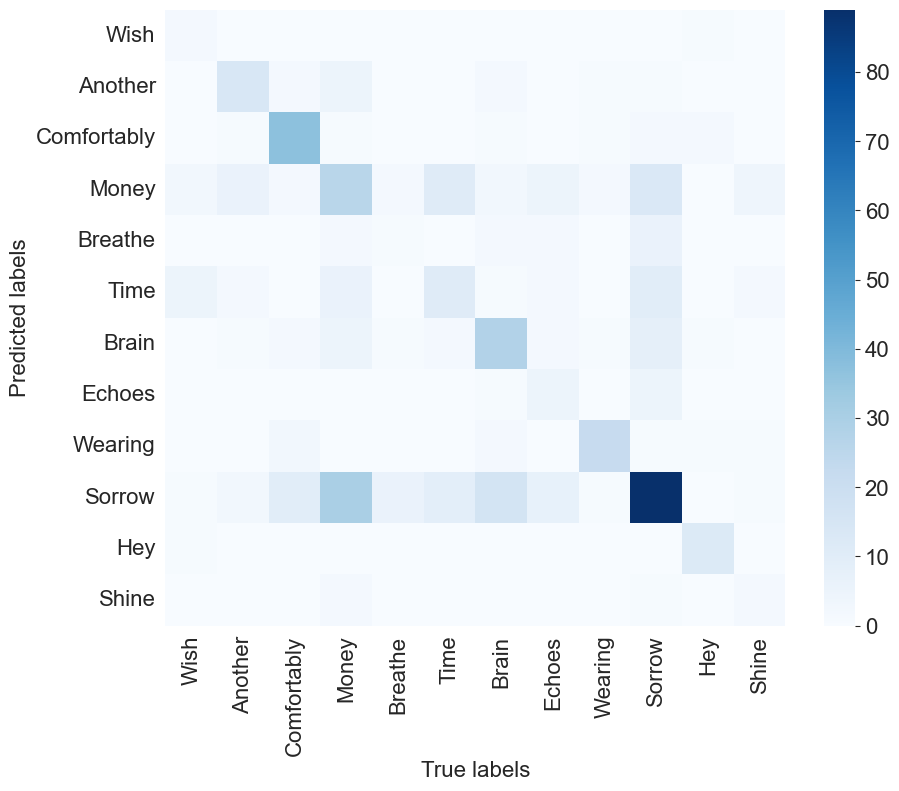

In [305]:
# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### HYBRID CNN-LSTM


In [66]:
def build_Hybrid(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256, 7, padding='same', activation='relu')(input_layer)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.2, seed=seed)(gap)

    lstm = tfkl.LSTM(128, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    lstm = tfkl.LSTM(128)(lstm)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE
    dropout = tfkl.Dropout(.2, seed=seed)(lstm)

    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model